In [ ]:
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive')
OUT = "/content/drive/MyDrive/early_egypt"
os.makedirs(OUT, exist_ok=True)

Mounted at /content/drive


In [ ]:
import json
import pandas as pd

vocab_path = "/content/drive/MyDrive/Древние языки/vocabulary/"

with open(vocab_path + "aaew_wlist.json", "r", encoding="utf-8") as f:
    wordlist = json.load(f)

def extract_entry(entry):
    """Извлекает полезную информацию из одной леммы AAeW."""

    lemma_id = entry.get("_id", "")

    name = entry.get("name", "")

    graphics = []
    for w in entry.get("words", []):
        for g in w.get("graphics", []):
            code = g.get("code")
            if code:
                graphics.append(code)

    translations = entry.get("translations", {}).get("translations", [])
    en_translations = [
        t["value"] for t in translations
        if t.get("lang") == "en" and "value" in t
    ]
    en_translation = "; ".join(en_translations)

    passport_items = {}

    passport = entry.get("passport", {})
    for group in passport.get("children", []):
        for subgroup in group.get("children", []):

            for item in subgroup.get("children", []):
                if isinstance(item, dict) and item.get("eClass","").endswith("BTSPassportEntryItem"):
                    value = item.get("value", "")
                    key = item.get("type", "")
                    passport_items[key] = value

    pos = passport_items.get("word_class", "")
    wclassnum = passport_items.get("wclassnum", "")
    woart = passport_items.get("woart", "")

    return {
        "id": lemma_id,
        "name": name,
        "pos": pos,
        "wclassnum": wclassnum,
        "woart": woart,
        "translation_en": en_translation,
        "graphics": " ".join(graphics)
    }


records = [extract_entry(entry) for entry in wordlist]

translation_df = pd.DataFrame(records)


In [ ]:
translation_df[translation_df['name'] == 'mw.t']

id  name pos wclassnum woart  \
15577  600401  mw.t  WS      1000  1002   
16580   69040  mw.t  WS      1020  1002   
16581   69050  mw.t  WS      1020  1002   
16582   69060  mw.t  WS      1020  1002   
16583   69070  mw.t  WS      1000  1002   
16584   69080  mw.t  WS      1020  1002   
26801  857378  mw.t          1020     0   

                               translation_en    graphics  
15577         [vulture, only as a hieroglyph]      G14 X1  
16580                                  mother      G14 X1  
16581                [part of a plant (med.)]   G14 X1 Z2  
16582                                          G14 X1 O39  
16583                                  [town]              
16584  trough (of a coffin, of a sarcophagus)              
26801

In [ ]:
import pandas as pd


HUMAN_DETERMINATIVES = {"A1", "A2", "A40", "A50", "G14"}

def parse_graphics(g):
    """Разбирает строку 'G14 X1 Z2' в список ['G14','X1','Z2']"""
    if pd.isna(g):
        return []
    return [x.strip() for x in g.split()]

def score_entry(row):
    score = 0

    graphics = parse_graphics(row["graphics"])
    trans = row["translation_en"] or ""

    if "only as a hieroglyph" in trans.lower():
        score -= 5
    if "as a sign" in trans.lower():
        score -= 4

    if "G14" in graphics:
        score += 5

    if graphics == ["G14", "X1"]:
        score += 4

    if "Z2" in graphics:
        score -= 2

    if "O39" in graphics:
        score -= 3

    if row.get("wclassnum") == 1020:
        score += 1

    if not trans.strip():
        score -= 3

    return score



def search_word(df, word):
    """Ищет слово по транслитерации и рейтингу выбирает лучшее значение."""
    candidates = df[df["name"] == word].copy()

    if candidates.empty:
        return None, pd.DataFrame()

    candidates["score"] = candidates.apply(score_entry, axis=1)

    best_row = candidates.sort_values("score", ascending=False).iloc[0]

    return best_row, candidates.sort_values("score", ascending=False)


In [ ]:
best, all_candidates = search_word(df, "mw.t")

print("Лучший перевод:", best["translation_en"])
print()
print(all_candidates[["id","name","graphics","translation_en","score"]])


Лучший перевод: mother

           id  name    graphics                          translation_en  score
16580   69040  mw.t      G14 X1                                  mother      9
15577  600401  mw.t      G14 X1         [vulture, only as a hieroglyph]      4
16581   69050  mw.t   G14 X1 Z2                [part of a plant (med.)]      3
16583   69070  mw.t                                              [town]      0
16584   69080  mw.t              trough (of a coffin, of a sarcophagus)      0
16582   69060  mw.t  G14 X1 O39                                             -1
26801  857378  mw.t                                                         -3


In [ ]:
df

id         name pos wclassnum woart  \
0           1            ꜣ  XX      1010     3   
1          10        ꜣj.wj  WS      1010  1003   
2         100          Ꜣbḏ  WS     10020  1001   
3      100000   ḥw.t-šn.wt  WS     10045  1102   
4      100010      ḥw.t-kꜣ  WS      1000  1102   
...       ...          ...  ..       ...   ...   
38770   99940     ḥw.t-nṯr  WS      1000  1102   
38771   99950  ḥw.t-ḥmꜣg.t  WS      1020  1102   
38772   99960    Ḥw.t-Ḥr.w  NG     10020  1102   
38773   99970    Ḥw.t-Ḥr.w  TI     10080  1102   
38774   99990   Ḥw.t-sbq.t  WS     10040  1102   

                                          translation_en             graphics  
0                                   vulture; bird (gen.)                   G1  
1                                pair of bandages (med.)  G1 M17 G43 Z4 V1 V1  
2                                                 Fisher                       
3          Mansion-of-? (sanctuary of Nut at Heliopolis)      O7 V7 M17 X1 V1  
4      ka-house (tomb chapel); chapel (for a statue i...            O6 X1 D28  
...                                                  ...                  ...  
38770                                             temple          R8 O6 X1 O1  
38771                           mansion of mummification                       
38772                                             Hathor                  O10  
38773               Hathor (epithet of a deceased woman)                  O10  
38774  Mansion-of-the-leg (room at Edfu sacred to lun...                       

[38775 rows x 7 columns]

In [ ]:
def print_translations_for_word(word, df):
    """Печатает ВСЕ переводы слова, отсортированные по score."""
    subset = df[df["name"] == word].copy()

    if subset.empty:
        print(f"\n[No data {word}]")
        return

    subset["score"] = subset.apply(score_entry, axis=1)
    subset = subset.sort_values("score", ascending=False)

    print(f"{word}")
    for _, row in subset.iterrows():
        print(f"{row['translation_en']}")

In [ ]:
import os
import time
import json
import numpy as np
import random
from gensim.models import Word2Vec, FastText
from itertools import product


def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)


def load_corpus(path):
    sentences = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.strip().split()
            if len(tokens) >= 2:
                sentences.append(tokens)
    return sentences



def get_word2vec_grid():
    return [
        # Базовые
        {'name': 'baseline', 'vector_size': 100, 'window': 5, 'min_count': 5, 'sg': 0, 'epochs': 20,
         'negative': 5, 'sample': 1e-3, 'alpha': 0.025},

        # Размер векторов
        {'name': 'vec50',  'vector_size': 50, 'window': 5, 'min_count': 5, 'sg': 0, 'epochs': 20,
         'negative': 5, 'sample': 1e-3, 'alpha': 0.025},
        {'name': 'vec200', 'vector_size': 200,'window': 5, 'min_count': 5, 'sg': 0, 'epochs': 20,
         'negative': 5, 'sample': 1e-3, 'alpha': 0.025},
        {'name': 'vec300', 'vector_size': 300,'window': 5, 'min_count': 5, 'sg': 0, 'epochs': 30,
         'negative': 10, 'sample': 1e-3, 'alpha': 0.025},

        # Окно
        {'name': 'win3',  'vector_size': 100,'window': 3, 'min_count': 5, 'sg': 0, 'epochs': 20,
         'negative': 5, 'sample': 1e-3, 'alpha': 0.025},
        {'name': 'win10', 'vector_size': 100,'window': 10,'min_count': 5, 'sg': 0, 'epochs': 20,
         'negative': 5, 'sample': 1e-3, 'alpha': 0.025},

        # min_count
        {'name': 'mincount3',  'vector_size': 100,'window': 5, 'min_count': 3,  'sg': 0, 'epochs': 20,
         'negative': 5, 'sample': 1e-3, 'alpha': 0.025},
        {'name': 'mincount10', 'vector_size': 100,'window': 5, 'min_count': 10, 'sg': 0, 'epochs': 20,
         'negative': 5, 'sample': 1e-3, 'alpha': 0.025},

        # Skip-gram
        {'name': 'skipgram', 'vector_size': 100,'window': 5, 'min_count': 5, 'sg': 1, 'epochs': 20,
         'negative': 10, 'sample': 1e-4, 'alpha': 0.03},

        # Много эпох
        {'name': 'epochs50', 'vector_size': 100,'window': 5, 'min_count': 5, 'sg': 0, 'epochs': 50,
         'negative': 5, 'sample': 1e-3, 'alpha': 0.025},
    ]



def get_fasttext_grid():
    return [
        {'name': 'ft_baseline', 'vector_size': 100, 'window': 5, 'min_count': 5,
         'epochs': 20, 'sg': 1, 'min_n': 2, 'max_n': 5},

        {'name': 'ft_big300', 'vector_size': 300, 'window': 5, 'min_count': 5,
         'epochs': 30, 'sg': 1, 'min_n': 2, 'max_n': 6},

        {'name': 'ft_win10', 'vector_size': 100, 'window': 10, 'min_count': 5,
         'epochs': 20, 'sg': 1, 'min_n': 2, 'max_n': 4},
    ]



def train_models(sentences, output_dir, thes_only=False):
    os.makedirs(output_dir, exist_ok=True)
    results = []

    grids = get_word2vec_grid()
    ft_grids = get_fasttext_grid()

    all_configs = [(cfg, 'word2vec') for cfg in grids] + [(cfg, 'fasttext') for cfg in ft_grids]

    for cfg, model_type in all_configs:
        cfg = cfg.copy()
        name = cfg.pop('name')

        print(f"Обучение {model_type.upper()}: {name}")

        start = time.time()

        if model_type == 'word2vec':
            model = Word2Vec(sentences=sentences, workers=4, **cfg)

        else:
            model = FastText(sentences=sentences, workers=4, **cfg)

        train_time = round(time.time() - start, 2)

        # путь
        suffix = "_thes_only" if thes_only else ""
        path = f"{output_dir}/{model_type}_{name}{suffix}.model"
        model.save(path)


        print(f" слов в словаре: {len(model.wv)}")
        print(f" время: {train_time} сек")

        results.append({
            "model_type": model_type,
            "name": name,
            "params": cfg,
            "vocab_size": len(model.wv),
            "path": path,
            "time_sec": train_time
        })

    # сохраняем лог
    with open(f"{output_dir}/training_log.json", "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    return results



def main_experiments(corpus_full, corpus_thes, output_dir):
    set_seed(42)

    print("\n### FULL CORPUS ###")
    s_full = load_corpus(corpus_full)
    train_models(s_full, output_dir, thes_only=False)

    print("\n### THESAURUS ONLY ###")
    s_thes = load_corpus(corpus_thes)
    train_models(s_thes, output_dir, thes_only=True)


**Эксперименты с параметрами:**

1) vector_size

2) window

3) min_count — минимальная частота токена для включения в словарь.

4) sg : или 0


In [ ]:
main_experiments(
    corpus_full='/content/drive/MyDrive/Древние языки/w2v_data/altes_reich_lemmas_NORMALIZED.txt',
    corpus_thes ='/content/drive/MyDrive/Древние языки/w2v_data/corpus_lemmatized_filtered.txt',
    output_dir='/content/drive/MyDrive/Древние языки/w2v_experiments'
)


### FULL CORPUS ###

===== Обучение WORD2VEC: baseline =====
{'vector_size': 100, 'window': 5, 'min_count': 5, 'sg': 0, 'epochs': 20, 'negative': 5, 'sample': 0.001, 'alpha': 0.025}
 → сохранена: /content/drive/MyDrive/Древние языки/w2v_experiments/word2vec_baseline.model
 → слов в словаре: 2643
 → время: 7.52 сек

===== Обучение WORD2VEC: vec50 =====
{'vector_size': 50, 'window': 5, 'min_count': 5, 'sg': 0, 'epochs': 20, 'negative': 5, 'sample': 0.001, 'alpha': 0.025}
 → сохранена: /content/drive/MyDrive/Древние языки/w2v_experiments/word2vec_vec50.model
 → слов в словаре: 2643
 → время: 5.67 сек

===== Обучение WORD2VEC: vec200 =====
{'vector_size': 200, 'window': 5, 'min_count': 5, 'sg': 0, 'epochs': 20, 'negative': 5, 'sample': 0.001, 'alpha': 0.025}
 → сохранена: /content/drive/MyDrive/Древние языки/w2v_experiments/word2vec_vec200.model
 → слов в словаре: 2643
 → время: 8.47 сек

===== Обучение WORD2VEC: vec300 =====
{'vector_size': 300, 'window': 5, 'min_count': 5, 'sg': 0, 'epo

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [ ]:
import os
import pandas as pd
from gensim.models import Word2Vec

models_path = "/content/drive/MyDrive/Древние языки/w2v_experiments/"

def get_translations(word, df):
    subset = df[df["name"] == word]
    if subset.empty:
        return ""

    trans = subset["translation_en"].fillna("").tolist()
    trans = [t for t in trans if t.strip() != ""]

    if not trans:
        return ""
    return "; ".join(trans)


model_files = [
    f for f in os.listdir(models_path)
    if f.endswith(".model") or f.endswith(".bin")
]

print(f"Найдено моделей: {len(model_files)}")


def table_results(model_files, topn = 6, target = "mw.t"):

  wide_table = pd.DataFrame(index=range(1, topn+1))


  for model_name in model_files:
      model_path = os.path.join(models_path, model_name)

      try:
          model = Word2Vec.load(model_path)
      except:
          continue

      try:
          neighbors = model.wv.most_similar(target, topn=topn)
      except KeyError:
          print(f"{target} отсутствует в модели, пропускаю.")
          continue

      col = []

      for word, score in neighbors:
          trans = get_translations(word, df)
          if trans:
              cell = f"{word} — {trans}"
          else:
              cell = word

          col.append(cell)

      while len(col) < topn:
          col.append("")

      wide_table[model_name] = col

  return wide_table


Найдено моделей: 26


In [ ]:
wide_table = table_results(model_files, topn = 6, target = "mw.t")
wide_table_god = table_results(model_files, topn = 6, target = "nṯr")
wide_table_father = table_results(model_files, topn = 6, target = "jtj")
wide_table_king = table_results(model_files, topn = 6, target = "nswt")
wide_table_to_do = table_results(model_files, topn = 6, target = "jri̯")
wide_table_to_listen = table_results(model_files, topn = 6, target = "sḏm")
wide_table_life = table_results(model_files, topn = 6, target = "ꜥnḫ")
wide_table_to_love = table_results(model_files, topn = 6, target = "mri̯")
wide_table_water = table_results(model_files, topn = 6, target = "mw")
wide_table_house = table_results(model_files, topn = 6, target = "pr")

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
def combine_all_tables(tables_dict):
    """
    Объединяет все таблицы с добавлением колонки target_word.

    Parameters:
    -----------
    tables_dict : dict
        {'target_word': dataframe}
    """
    combined = []

    for target_word, df in tables_dict.items():
        df_copy = df.copy()
        df_copy.insert(0, 'target_word', target_word)
        df_copy.insert(1, 'rank', range(1, len(df_copy) + 1))
        combined.append(df_copy)

    result = pd.concat(combined, ignore_index=True)
    return result

In [ ]:
all_tables = {
    'mw.t': wide_table,
    'nṯr': wide_table_god,
    'jtj': wide_table_father,
    'nswt': wide_table_king,
    'jri̯': wide_table_to_do,
    'sḏm': wide_table_to_listen,
    'ꜥnḫ': wide_table_life,
    'mri̯': wide_table_to_love,
    'mw': wide_table_water,
    'pr': wide_table_house,
}
combined_df = combine_all_tables(all_tables)

In [ ]:
combined_df.to_excel("combined_df.xlsx", index=False)

In [ ]:
import pandas as pd

def split_word_and_translation(cell):
    if isinstance(cell, str) and "—" in cell:
        word, translation = cell.split("—", 1)
        return word.strip(), translation.strip()
    elif isinstance(cell, str):
        return cell.strip(), ""
    return "", ""

words_only = combined_df.copy()
translations_only = combined_df.copy()

for col in combined_df.columns:
    if col not in ["target_word", "rank"]:
        words_only[col] = combined_df[col].apply(lambda x: split_word_and_translation(x)[0])
        translations_only[col] = combined_df[col].apply(lambda x: split_word_and_translation(x)[1])

long_words = (
    words_only
    .melt(id_vars=["target_word", "rank"], var_name="model", value_name="word")
)

long_transl = (
    translations_only
    .melt(id_vars=["target_word", "rank"], var_name="model", value_name="translation")
)


long_df = pd.concat([long_words, long_transl["translation"]], axis=1)

long_df = long_df[long_df["word"] != ""]

intersection_by_target = (
    long_df.groupby(["target_word", "word", "translation"])["model"]
    .apply(list)
    .reset_index()
)

intersection_by_target["count"] = intersection_by_target["model"].apply(len)

intersection_by_target = intersection_by_target.sort_values(
    ["target_word", "count"], ascending=[True, False]
)


In [ ]:
intersection_by_target

target_word    word  \
36         jri̯      ḏd   
26         jri̯     wnn   
18         jri̯      nn   
33         jri̯    ıri̯   
0          jri̯      =j   
..          ...     ...   
332         ꜥnḫ     twꜣ   
334         ꜥnḫ     wrḥ   
336         ꜥnḫ  zꜣ-Rꜥw   
342         ꜥnḫ    ḫr.j   
345         ꜥnḫ     ꜥnḏ   

                                                                                                                                                                            translation  \
36                                                                                                                to say; to tell; column; back bone; to slaughter; stability; duration   
26                                                                                                                                                    [auxilliary]; to exist; to become   
18   [negative word, distinct from n]; this (demons. pron.); darkness; likeness; image; food; flood water; [a stone for making divine statues]; [variant of the particle of negation n]   
33                                                                                                                                                                                        
0                                                                                                                                        I; me; my, mine (suffix pron., 1st per. sing.)   
..                                                                                                                                                                                  ...   
332          man of low station; inferior; to put a claim (on someone); to appeal (to someone); to lean on; to support; to raise; bearer (an unguent vessel); pillar; lintel (or jamb?)   
334                                                                                                               to dance; to annoint; to smear; ointment; ointment vessel (a measure)   
336                                                                                                                                                                           son of Re   
342                                                                                                                                                                              Syrian   
345                                                                                                       [part of a falcon's wing (tip?)]; to be few; to be diminished; few; deficient   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         model  \
36   [word2vec_baseline.model, word2vec_vec50.model, word2vec_vec300.model, word2vec_win3.model, word2vec_mincount3.model, word2vec_mincount10.model, word2vec_epochs50.model, word2vec_baseline_thes_only.model, word2vec_vec50_thes_only.model, word2vec_vec200_thes_only.model, word2vec_vec300_thes_only.model, word2vec_win3_thes_only.model, word2vec_win10_thes_only.model, word2vec_mincount3_thes_only.model, word2vec_mincount10_thes_only.model, word2vec_epochs50_thes_only.model]   
26                           [word2vec_baseline.model, word2vec_vec200.model, word2vec_vec300.model, word2vec_win10.model, word2vec_mincount10.model, word2vec_epochs50.model, word2vec_baseline_thes_only.model, word2vec_vec50_thes_only.model, word2vec_vec200_thes_only.model, word2vec_vec300_thes_only.model, word2vec_win3_thes_only.model, word2vec_win10_thes_only.model, word2vec_mincount3_thes_only.model, word2vec_mincount10_thes_only.model, word2vec_epochs50_thes_onl

In [ ]:
intersection_by_target.to_excel("intersection_by_target.xlsx", index=False)

по поводу слов для wsi:

основное слово это sDm, ещё есть вот такие:

jri (Делать – 8873 аттестации)

nTr (Бог – 8295 аттестаций)

anx (Как глагол жить – 3086 аттестаций, как существительно жизнь – 2996 аттестаций)

nswt (Царь, Фараон – 2798 аттестации)

mri (Любить – 2424 аттестации)

mw (Вода – 2000 аттестаций)

pr (Дом – 1534 аттестации)

In [ ]:
pd.set_option('display.max_colwidth', None)


Количество целевых слов: 10
Целевые слова: mw.t, nṯr, jtj, nswt, jri̯, sḏm, ꜥnḫ, mri̯, mw, pr

Количество моделей: 25

 АНАЛИЗ СТАБИЛЬНОСТИ СОСЕДЕЙ

Целевое слово: mw.t
----------------------------------------------------------------------

Всего уникальных соседей: 27

Топ-10 самых стабильных соседей (встречаются в большинстве моделей):
  16/25 ( 64.0%) | n-jw.t               | 
  15/25 ( 60.0%) | Nw.t                 | Nut
  12/25 ( 48.0%) | mrw.t                | love; belovedness
  12/25 ( 48.0%) | ẖ.t                  | body; belly; womb; body (of gods; of men
  12/25 ( 48.0%) | ẖnm                  | [a vessel (of stone or metal)]; to join;
  11/25 ( 44.0%) | gꜣu̯                 | to be narrow; to be constricted; to lack
  11/25 ( 44.0%) | ẖnm.t-wr.t           | great strainer (Nut)
  10/25 ( 40.0%) | ḥꜥjꜥi̯               | 
  8/25 ( 32.0%) | sn.t                 | sister; beloved; polishing stone; flag p
  6/25 ( 24.0%) | jw.t                 | [ship's cordage (?)]; [an instru

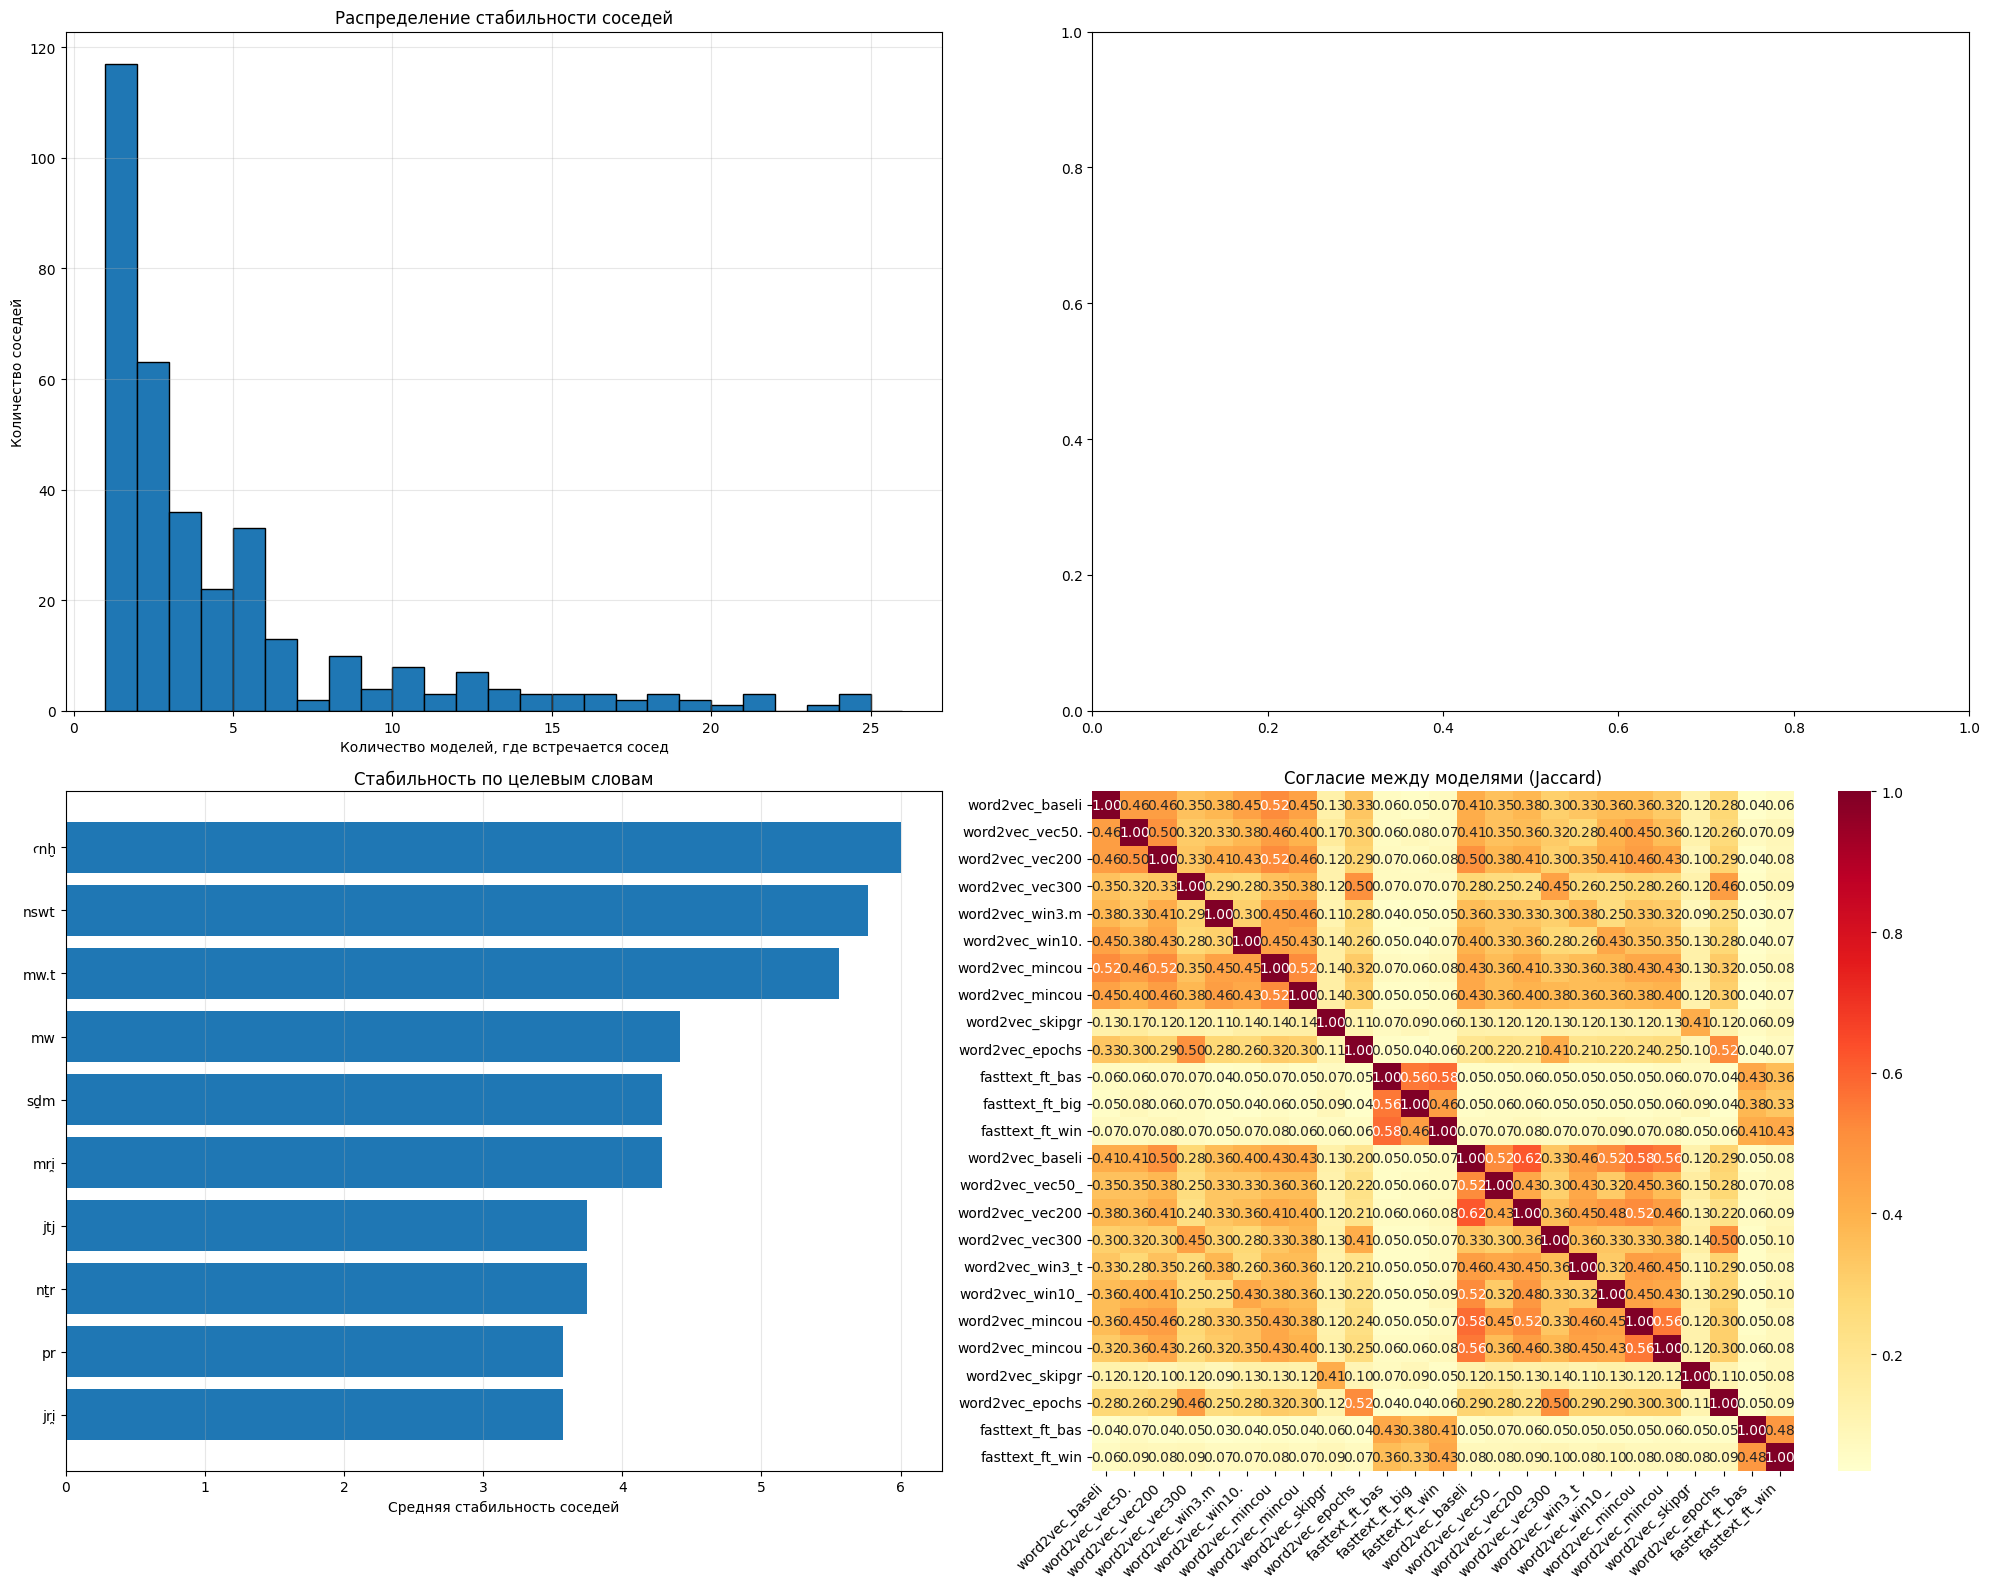

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


print(f"\nКоличество целевых слов: {combined_df['target_word'].nunique()}")
print(f"Целевые слова: {', '.join(combined_df['target_word'].unique())}")

model_columns = [col for col in combined_df.columns if col not in ['target_word', 'rank']]
print(f"\nКоличество моделей: {len(model_columns)}")

print("\n" + "="*70)
print(" АНАЛИЗ СТАБИЛЬНОСТИ СОСЕДЕЙ")
print("="*70)

for target in combined_df['target_word'].unique():
    print(f"\nЦелевое слово: {target}")
    print("-"*70)

    target_data = intersection_df[intersection_df['target_word'] == target]
    target_data_sorted = target_data.sort_values('count', ascending=False)

    print(f"\nВсего уникальных соседей: {len(target_data)}")

    print(f"\nТоп-10 самых стабильных соседей (встречаются в большинстве моделей):")
    for i, row in target_data_sorted.head(10).iterrows():
        word = str(row['word']) if pd.notna(row['word']) else ""
        translation = str(row['translation']) if pd.notna(row['translation']) else ""
        count = int(row['count'])

        percentage = (count / len(model_columns)) * 100

        trans_display = translation[:40] if len(translation) > 40 else translation

        print(f"  {count}/{len(model_columns)} ({percentage:5.1f}%) | {word:20s} | {trans_display}")

    unique_neighbors = target_data[target_data['count'] == 1]
    print(f"Соседи только в 1 модели : {len(unique_neighbors)}")


    stable_neighbors = target_data[target_data['count'] == len(model_columns)]
    print(f"Соседи во ВСЕХ моделях: {len(stable_neighbors)}")
    if len(stable_neighbors) > 0:
        for idx, row in stable_neighbors.iterrows():
            word = str(row['word']) if pd.notna(row['word']) else ""
            trans = str(row['translation']) if pd.notna(row['translation']) else ""
            print(f"    • {word} — {trans}")






print("\n" + "="*70)
print("РЕЙТИНГ МОДЕЛЕЙ ПО ЧАСТОТЕ ВСТРЕЧАЕМОСТИ СОСЕДЕЙ")
print("="*70)


model_scores = []

for model in model_columns:
    model_neighbors = []

    for target in combined_df['target_word'].unique():
        target_rows = combined_df[combined_df['target_word'] == target]
        neighbors = target_rows[model].dropna().tolist()


        for neighbor in neighbors:
            if isinstance(neighbor, str) and neighbor.strip():
                word = neighbor.split('—')[0].strip() if '—' in neighbor else neighbor.strip()
                if word:
                    model_neighbors.append((target, word))


    overlap_scores = []
    for target, word in model_neighbors:
        target_data = intersection_df[
            (intersection_df['target_word'] == target) &
            (intersection_df['word'] == word)
        ]
        if not target_data.empty:
            count = target_data.iloc[0]['count']
            overlap_scores.append(count)

    avg_overlap = np.mean(overlap_scores) if overlap_scores else 0


    model_scores.append({
        'model': model,
        'total_neighbors': len(model_neighbors),
        'avg_overlap': avg_overlap,
    })

model_ranking = pd.DataFrame(model_scores)
model_ranking = model_ranking.sort_values('avg_overlap', ascending=False)

print("\nРЕЙТИНГ МОДЕЛЕЙ:")
print(model_ranking.to_string(index=False))


print("\n" + "="*70)
print("ГРАФИКИ")
print("="*70)


fig, axes = plt.subplots(2, 2, figsize=(20, 16))


ax1 = axes[0, 0]
intersection_df['count'].hist(bins=range(1, len(model_columns)+2), ax=ax1, edgecolor='black')
ax1.set_xlabel('Количество моделей, где встречается сосед')
ax1.set_ylabel('Количество соседей')
ax1.set_title('Распределение стабильности соседей')
ax1.grid(alpha=0.3)


ax3 = axes[1, 0]
target_stability = intersection_df.groupby('target_word')['count'].mean().sort_values()
ax3.barh(target_stability.index, target_stability.values)
ax3.set_xlabel('Средняя стабильность соседей')
ax3.set_title('Стабильность по целевым словам')
ax3.grid(alpha=0.3, axis='x')


ax4 = axes[1, 1]

agreement_matrix = np.zeros((len(model_columns), len(model_columns)))

for i, model1 in enumerate(model_columns):
    for j, model2 in enumerate(model_columns):
        if i == j:
            agreement_matrix[i, j] = 1.0
            continue

        neighbors1 = set()
        neighbors2 = set()

        for target in combined_df['target_word'].unique():
            target_rows = combined_df[combined_df['target_word'] == target]

            n1 = target_rows[model1].dropna().tolist()
            n2 = target_rows[model2].dropna().tolist()

            for n in n1:
                if isinstance(n, str):
                    word = n.split('—')[0].strip() if '—' in n else n.strip()
                    neighbors1.add((target, word))

            for n in n2:
                if isinstance(n, str):
                    word = n.split('—')[0].strip() if '—' in n else n.strip()
                    neighbors2.add((target, word))

        intersection = len(neighbors1 & neighbors2)
        union = len(neighbors1 | neighbors2)
        agreement_matrix[i, j] = intersection / union if union > 0 else 0

sns.heatmap(agreement_matrix,
            xticklabels=[m[:15] for m in model_columns],
            yticklabels=[m[:15] for m in model_columns],
            annot=True, fmt='.2f', cmap='YlOrRd', ax=ax4)
ax4.set_title('Согласие между моделями (Jaccard)')
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax4.get_yticklabels(), rotation=0)

plt.tight_layout()

In [ ]:
long_df = combined_df.melt(
    id_vars=["target_word", "rank"],
    var_name="model",
    value_name="neighbor"
)


long_df = long_df.dropna(subset=["neighbor"])

In [ ]:
long_df

target_word  rank                              model  \
0           mw.t     1            word2vec_baseline.model   
1           mw.t     2            word2vec_baseline.model   
2           mw.t     3            word2vec_baseline.model   
3           mw.t     4            word2vec_baseline.model   
4           mw.t     5            word2vec_baseline.model   
...          ...   ...                                ...   
1495          pr     2  fasttext_ft_win10_thes_only.model   
1496          pr     3  fasttext_ft_win10_thes_only.model   
1497          pr     4  fasttext_ft_win10_thes_only.model   
1498          pr     5  fasttext_ft_win10_thes_only.model   
1499          pr     6  fasttext_ft_win10_thes_only.model   

                                                                                                                                                                              neighbor  
0                                                                                                                                                                               ḥꜥjꜥi̯  
1                                                                                                                                                                           Nw.t — Nut  
2                                                                                                                          gꜣu̯ — to be narrow; to be constricted; to lack; to deprive  
3                                                                                                                                                    ẖnm.t-wr.t — great strainer (Nut)  
4     ẖnm — [a vessel (of stone or metal)]; to join; to unite with; citizens; companions; dependants; to build; to construct; [one of the seven sacred oils]; basin (?) for irrigation  
...                                                                                                                                                                                ...  
1495                                                                                                                             pr-ḏ.t — funerary foundation (lit. house of eternity)  
1496                                                                                                                                        mḏ.t — binding; hobble; byre; oil; unguent  
1497                                                                                                                 zꜣ-pr — grassland; byre; watchman (lit. son of the house); police  
1498                                                                                                                                                                  pr-ḥḏ — treasury  
1499                                                                                                                                              pzḥ — to bite; to sting; bite; sting  

[1500 rows x 4 columns]

In [ ]:
import pandas as pd
import gensim
import umap
import plotly.express as px
import numpy as np
from tqdm import tqdm

def plot_full_vocabulary_with_translations(model_path, translations_df, max_words=5000):
    """
    Визуализация всего словаря модели с переводами

    Parameters:
    -----------
    model_path : str
        Путь к модели Word2Vec
    translations_df : DataFrame
        DataFrame с колонками 'name' (слово) и 'translation_en' (перевод)
    max_words : int
        Максимальное количество слов для визуализации
    """


    print(f"Загрузка модели {model_path.split('/')[-1]}...")
    model = gensim.models.Word2Vec.load(model_path)


    all_words = list(model.wv.key_to_index.keys())

    if len(all_words) > max_words:
        print(f"Словарь модели содержит {len(all_words)} слов. Ограничиваем до {max_words} самых частых...")
        all_words = model.wv.index_to_key[:max_words]
    else:
        print(f"Визуализация всего словаря: {len(all_words)} слов")


    translations_dict = {}
    for _, row in translations_df.iterrows():
        word = str(row['name']).strip()
        translation = str(row['translation_en']).strip()
        if word and translation and translation != 'nan':
            translations_dict[word] = translation


    vectors = []
    words_to_plot = []
    translations_list = []
    has_translation = []

    for word in tqdm(all_words):
        try:
            vectors.append(model.wv[word])
            words_to_plot.append(word)


            translation = translations_dict.get(word, "")
            translations_list.append(translation)
            has_translation.append(1 if translation else 0)
        except KeyError:
            continue

    vectors = np.array(vectors)


    print("Применение UMAP...")
    reducer = umap.UMAP(
        n_components=2,
        random_state=42,
        n_neighbors=15,
        min_dist=0.1,
        metric='cosine'
    )
    embedding = reducer.fit_transform(vectors)


    print("Создание визуализации...")
    plot_df = pd.DataFrame({
        'x': embedding[:, 0],
        'y': embedding[:, 1],
        'word': words_to_plot,
        'translation': translations_list,
        'has_translation': has_translation,
        'frequency_rank': range(len(words_to_plot))
    })


    def create_hover_text(row):
        if row['translation']:
            return f"{row['word']}<br>Translation: {row['translation']}"
        else:
            return row['word']

    plot_df['hover_text'] = plot_df.apply(create_hover_text, axis=1)


    fig = px.scatter(
        plot_df,
        x='x',
        y='y',
        hover_name='word',
        hover_data={
            'word': False,
            'translation': True,
            'x': False,
            'y': False,
            'hover_text': False,
            'frequency_rank': True,
            'has_translation': False
        },
        color='has_translation',
        color_discrete_map={0: 'lightgray', 1: 'blue'},
        title=f"Векторное пространство с переводами: {model_path.split('/')[-1]}<br>"
              f"{len(words_to_plot)} слов (синие: {sum(has_translation)} с переводом, серые: {len(has_translation)-sum(has_translation)} без перевода)",
        labels={
            'x': 'Компонента 1 (UMAP)',
            'y': 'Компонента 2 (UMAP)',
            'has_translation': 'Есть перевод',
            'translation': 'Перевод',
            'frequency_rank': 'Частота (ранг)'
        },
        size_max=10
    )


    fig.update_traces(
        marker=dict(
            size=5,
            opacity=0.7,
            line=dict(width=0.2, color='white')
        ),
        selector=dict(mode='markers')
    )

    fig.update_layout(
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial",
            align="left"
        ),
        width=1200,
        height=800,
        showlegend=True,
        template='plotly_white',
        legend_title_text='Наличие перевода'
    )


    fig.for_each_trace(lambda trace: trace.update(name="С переводом" if trace.name == "1" else "Без перевода"))


    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=list([
                    dict(
                        args=[{"marker.size": [3]}],
                        label="Маленькие точки",
                        method="restyle"
                    ),
                    dict(
                        args=[{"marker.size": [5]}],
                        label="Средние точки",
                        method="restyle"
                    ),
                    dict(
                        args=[{"marker.size": [8]}],
                        label="Крупные точки",
                        method="restyle"
                    ),
                    dict(
                        args=[{"marker.opacity": [0.3]}],
                        label="Прозрачные",
                        method="restyle"
                    ),
                    dict(
                        args=[{"marker.opacity": [0.7]}],
                        label="Нормальные",
                        method="restyle"
                    ),
                    dict(
                        args=[{"marker.opacity": [1.0]}],
                        label="Непрозрачные",
                        method="restyle"
                    )
                ]),
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )

    print("Отображение графика...")
    fig.show()


    return fig, plot_df


def search_words_in_space(model_path, search_words, translations_df):
    """
    Поиск и отображение конкретных слов в пространстве
    """
    print(f"Загрузка модели {model_path.split('/')[-1]}...")
    model = gensim.models.Word2Vec.load(model_path)


    translations_dict = {}
    for _, row in translations_df.iterrows():
        word = str(row['name']).strip()
        translation = str(row['translation_en']).strip()
        if word and translation and translation != 'nan':
            translations_dict[word] = translation


    found_words = []
    vectors = []
    translations = []

    for word in search_words:
        if word in model.wv.key_to_index:
            found_words.append(word)
            vectors.append(model.wv[word])
            translations.append(translations_dict.get(word, "Нет перевода"))

    print(f"Найдено {len(found_words)} из {len(search_words)} слов")

    if len(found_words) == 0:
        print("Не найдено ни одного слова!")
        return None


    reducer = umap.UMAP(n_components=2, random_state=42)
    vectors_array = np.array(vectors)
    embedding = reducer.fit_transform(vectors_array)


    plot_df = pd.DataFrame({
        'x': embedding[:, 0],
        'y': embedding[:, 1],
        'word': found_words,
        'translation': translations
    })


    fig = px.scatter(
        plot_df,
        x='x',
        y='y',
        hover_name='word',
        hover_data={'translation': True},
        text='word',
        title=f"Найденные слова в векторном пространстве: {model_path.split('/')[-1]}",
        labels={'x': 'UMAP1', 'y': 'UMAP2'}
    )

    fig.update_traces(
        marker=dict(size=15, color='red', opacity=0.8),
        textposition='top center'
    )

    fig.update_layout(
        hoverlabel=dict(bgcolor="white", font_size=12),
        width=800,
        height=600,
        showlegend=False
    )

    fig.show()
    return fig, plot_df


for model in models_list:
    model_path = f'/content/drive/MyDrive/Древние языки/w2v_experiments/{model}'


    fig, plot_df = plot_full_vocabulary_with_translations(
        model_path=model_path,
        translations_df=translation_df
    )

    fig.write_html(f"word_embeddings_with_translations_{model}.html")

Загрузка модели word2vec_baseline.model...
Визуализация всего словаря: 2643 слов


100%|██████████| 2643/2643 [00:00<00:00, 218056.29it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_vec50.model...
Визуализация всего словаря: 2643 слов


100%|██████████| 2643/2643 [00:00<00:00, 437748.60it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_vec200.model...
Визуализация всего словаря: 2643 слов


100%|██████████| 2643/2643 [00:00<00:00, 231233.09it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_vec300.model...
Визуализация всего словаря: 2643 слов


100%|██████████| 2643/2643 [00:00<00:00, 232576.90it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_win3.model...
Визуализация всего словаря: 2643 слов


100%|██████████| 2643/2643 [00:00<00:00, 436868.79it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_win10.model...
Визуализация всего словаря: 2643 слов


100%|██████████| 2643/2643 [00:00<00:00, 44270.82it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_mincount3.model...
Визуализация всего словаря: 3675 слов


100%|██████████| 3675/3675 [00:00<00:00, 439748.58it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_mincount10.model...
Визуализация всего словаря: 1695 слов


100%|██████████| 1695/1695 [00:00<00:00, 369163.22it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_skipgram.model...
Визуализация всего словаря: 2643 слов


100%|██████████| 2643/2643 [00:00<00:00, 184338.19it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_epochs50.model...
Визуализация всего словаря: 2643 слов


100%|██████████| 2643/2643 [00:00<00:00, 434573.89it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели fasttext_ft_baseline.model...
Визуализация всего словаря: 2643 слов


100%|██████████| 2643/2643 [00:00<00:00, 405959.84it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели fasttext_ft_big300.model...
Визуализация всего словаря: 2643 слов


100%|██████████| 2643/2643 [00:00<00:00, 219663.64it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели fasttext_ft_win10.model...
Визуализация всего словаря: 2643 слов


100%|██████████| 2643/2643 [00:00<00:00, 400301.36it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_baseline_thes_only.model...
Визуализация всего словаря: 2208 слов


100%|██████████| 2208/2208 [00:00<00:00, 250257.34it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_vec50_thes_only.model...
Визуализация всего словаря: 2208 слов


100%|██████████| 2208/2208 [00:00<00:00, 415851.96it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_vec200_thes_only.model...
Визуализация всего словаря: 2208 слов


100%|██████████| 2208/2208 [00:00<00:00, 426382.29it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_vec300_thes_only.model...
Визуализация всего словаря: 2208 слов


100%|██████████| 2208/2208 [00:00<00:00, 359400.16it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_win3_thes_only.model...
Визуализация всего словаря: 2208 слов


100%|██████████| 2208/2208 [00:00<00:00, 416375.47it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_win10_thes_only.model...
Визуализация всего словаря: 2208 слов


100%|██████████| 2208/2208 [00:00<00:00, 434973.61it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_mincount3_thes_only.model...
Визуализация всего словаря: 3052 слов


100%|██████████| 3052/3052 [00:00<00:00, 441307.82it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_mincount10_thes_only.model...
Визуализация всего словаря: 1422 слов


100%|██████████| 1422/1422 [00:00<00:00, 412069.94it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_skipgram_thes_only.model...
Визуализация всего словаря: 2208 слов


100%|██████████| 2208/2208 [00:00<00:00, 289226.21it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели word2vec_epochs50_thes_only.model...
Визуализация всего словаря: 2208 слов


100%|██████████| 2208/2208 [00:00<00:00, 416750.21it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели fasttext_ft_baseline_thes_only.model...
Визуализация всего словаря: 2208 слов


100%|██████████| 2208/2208 [00:00<00:00, 238760.01it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


Загрузка модели fasttext_ft_win10_thes_only.model...
Визуализация всего словаря: 2208 слов


100%|██████████| 2208/2208 [00:00<00:00, 402146.13it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Применение UMAP...
Создание визуализации...
Отображение графика...


In [ ]:
import os
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

models_path = "/content/drive/MyDrive/Древние языки/w2v_experiments/"
target = "mw.t"


def print_similar_words(model, target, topn=10):
    try:
        sims = model.wv.most_similar(target, topn=topn)
    except KeyError:
        print(f"Слова {target} нет в модели")
        return

    for w, score in sims:
        print(f"{w:15} → {score:.3f}")
    print("\n")


output_dir = os.path.join(models_path, "ego_graphs_clean")
os.makedirs(output_dir, exist_ok=True)

model_files = [
    f for f in os.listdir(models_path)
    if f.endswith(".model") or f.endswith(".bin")
]

print(f"Найдено моделей: {len(model_files)}")

for model_name in model_files:
    model_path = os.path.join(models_path, model_name)
    print(f"\n\n==== МОДЕЛЬ: {model_name} ====")


    try:
        model = Word2Vec.load(model_path)
    except Exception as e:
        print(f"Ошибка загрузки {model_name}: {e}")
        continue


    print_similar_words(model, target, topn=10)

    try:
        fig, G = plot_word_ego_network(
            model,
            target,
            topn=10,
            threshold=0.3,
            figsize=(7, 5),
            show_weights=False
        )
        out_img = os.path.join(output_dir, f"{model_name}_{target}.png")
        fig.savefig(out_img, dpi=200, bbox_inches='tight')
        plt.close(fig)
    except Exception as e:
        print(f"Ошибка построения графа: {e}")


Найдено моделей: 47


==== МОДЕЛЬ: w2v_vec200.model ====
rnpi̯           → 0.510
Nw.t            → 0.498
ẖ.t             → 0.484
ẖnm             → 0.476
gꜣu̯            → 0.473
mrw.t           → 0.471
ḥꜥjꜥi̯          → 0.459
ẖnm.t-wr.t      → 0.457
n-jw.t          → 0.454
jꜣq             → 0.451


rnpi̯
to be young; to become young (again)

Nw.t
Nut

ẖ.t
body; belly; womb
body (of gods; of men); generation
mass (of a substance)
section (of a building)
[a kind of stone (?)]
[a plant]
pit

ẖnm
[a vessel (of stone or metal)]
to join; to unite with
to build; to construct
basin (?) for irrigation
[one of the seven sacred oils]
citizens; companions; dependants





gꜣu̯
to be narrow; to be constricted; to lack; to deprive

mrw.t
love; belovedness
ḥꜥjꜥi̯

ẖnm.t-wr.t
great strainer (Nut)
n-jw.t

jꜣq
to crawl
to govern (?)
to climb up




==== МОДЕЛЬ: w2v_win10.model ====
ẖnm             → 0.570
gꜣu̯            → 0.555
ẖnm.t-wr.t      → 0.535
snq             → 0.521
Nw.t            → 0.520
rnpi

In [ ]:
def analyze_egyptian_ego_networks(model, output_dir):
    """
    Анализирует ego-сети для ключевых египетских слов.
    """
    print("="*70)
    print("АНАЛИЗ EGO-СЕТЕЙ")
    print("="*70)

    # Ключевые слова для анализа
    key_words = {
        'mw.t': 'мать',
        'nṯr': 'бог',
        'nswt': 'царь',
        'Wsjr': 'Осирис',
        'ꜥnḫ': 'жизнь',
        'jtj': 'отец',
    }

    for word, translation in key_words.items():
        if word not in model.wv:
            print(f"'{word}' ({translation}) не найдено в модели")
            continue

        print(f"Создание ГРАФА для '{word}' ({translation})")

        fig, G = plot_word_ego_network(
            model, word,
            topn=6,
            threshold=0.3,
            show_weights=False
        )


        neighbors = model.wv.most_similar(word, topn=10)
        print(f"Соседи:")
        for i, (w, score) in enumerate(neighbors, 1):
            print(f"     {i:2d}. {w:20s} ({score:.3f})")

    print("Картинка")
    words_to_show = [w for w in key_words.keys() if w in model.wv]

    if words_to_show:
        fig_multi = plot_multiple_ego_networks(
            model, words_to_show,
            topn=6, threshold=0.3
        )
        plt.close(fig_multi)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib import rcParams

rcParams['font.family'] = 'DejaVu Sans'

def plot_word_ego_network(model, target_word, topn=6,
                          threshold=0.3, figsize=(7, 5),
                          show_weights=True):
    """
    Визуализирует сеть похожих слов для одного целевого слова.

    Parameters:
    -----------
    model : Word2Vec model
    target_word : str
        Целевое слово (например, 'mw.t' - мать)
    topn : int
        Сколько ближайших соседей показать
    threshold : float
        Минимальная схожесть для показа связей между соседями
    show_weights : bool
        Показывать ли веса рёбер
    """

    if target_word not in model.wv:
        print(f"Слово '{target_word}' не найдено в модели")
        return None

    neighbors = model.wv.most_similar(target_word, topn=topn)
    neighbor_words = [w for w, _ in neighbors]
    neighbor_scores = [s for _, s in neighbors]

    G = nx.Graph()

    G.add_node(target_word, node_type='target')

    for word, score in neighbors:
        print_translations_for_word(word, df)
        G.add_node(word, node_type='neighbor')
        G.add_edge(target_word, word, weight=score)

    for i, word1 in enumerate(neighbor_words):
        for word2 in neighbor_words[i+1:]:
            try:
                similarity = model.wv.similarity(word1, word2)
                if similarity > threshold:
                    G.add_edge(word1, word2, weight=similarity, edge_type='neighbor')
            except:
                pass

    fig, ax = plt.subplots(figsize=figsize)

    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

    node_sizes = []
    for node in G.nodes():
        if node == target_word:
            node_sizes.append(3000)
        else:
            node_sizes.append(1500)

    node_colors = []
    for node in G.nodes():
        if node == target_word:
            node_colors.append('#FFD700')  # Золотой для центра
        else:
            node_colors.append('#FF6B6B')  # Красный для соседей

    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.9,
        edgecolors='black',
        linewidths=2,
        ax=ax
    )


    center_edges = [(target_word, n) for n in neighbor_words]
    nx.draw_networkx_edges(
        G, pos,
        edgelist=center_edges,
        width=3,
        alpha=0.6,
        edge_color='gray',
        ax=ax
    )


    neighbor_edges = [(u, v) for u, v, d in G.edges(data=True)
                      if u != target_word and v != target_word]
    if neighbor_edges:
        nx.draw_networkx_edges(
            G, pos,
            edgelist=neighbor_edges,
            width=1,
            alpha=0.3,
            edge_color='lightgray',
            style='dashed',
            ax=ax
        )

    nx.draw_networkx_labels(
        G, pos,
        font_size=12,
        font_weight='bold',
        font_family='DejaVu Sans',
        ax=ax
    )

    if show_weights:
        edge_labels = {}
        for u, v, d in G.edges(data=True):
            if u == target_word or v == target_word:
                edge_labels[(u, v)] = f"{d['weight']:.2f}"

        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_size=9,
            ax=ax
        )

    ax.set_title(f"Сеть похожих слов для '{target_word}'",
                fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    plt.tight_layout()

    return fig, G


def plot_multiple_ego_networks(model, words_list, topn=6,
                               threshold=0.3, figsize=(8, 6)):
    """
    Визуализирует несколько ego-сетей на одном изображении.
    """
    n_words = len(words_list)
    n_cols = 3
    n_rows = (n_words + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.array(axes).flatten()

    for idx, word in enumerate(words_list):
        ax = axes[idx]

        if word not in model.wv:
            ax.text(0.5, 0.5, f"'{word}'\nне найдено",
                   ha='center', va='center', fontsize=12)
            ax.axis('off')
            continue

        neighbors = model.wv.most_similar(word, topn=topn)
        neighbor_words = [w for w, _ in neighbors]

        G = nx.Graph()
        G.add_node(word, node_type='target')

        for w, score in neighbors:
            G.add_node(w, node_type='neighbor')
            G.add_edge(word, w, weight=score)

        for i, w1 in enumerate(neighbor_words):
            for w2 in neighbor_words[i+1:]:
                try:
                    sim = model.wv.similarity(w1, w2)
                    if sim > threshold:
                        G.add_edge(w1, w2, weight=sim)
                except:
                    pass

        pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)

        node_sizes = [2000 if n == word else 1000 for n in G.nodes()]
        node_colors = ['#FFD700' if n == word else '#FF6B6B' for n in G.nodes()]

        nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                              node_color=node_colors, alpha=0.9,
                              edgecolors='black', linewidths=1.5, ax=ax)

        center_edges = [(word, n) for n in neighbor_words]
        nx.draw_networkx_edges(G, pos, edgelist=center_edges,
                              width=2, alpha=0.5, ax=ax)

        neighbor_edges = [(u, v) for u, v in G.edges()
                         if u != word and v != word]
        if neighbor_edges:
            nx.draw_networkx_edges(G, pos, edgelist=neighbor_edges,
                                  width=0.5, alpha=0.2, style='dashed', ax=ax)

        nx.draw_networkx_labels(G, pos, font_size=9,
                               font_weight='bold', ax=ax)

        ax.set_title(f"'{word}'", fontsize=12, fontweight='bold')
        ax.axis('off')

    for idx in range(n_words, len(axes)):
        axes[idx].axis('off')

    plt.suptitle("Сети похожих слов", fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()

    return fig


def compare_ego_networks_across_models(models_dict, target_word,
                                       topn=6, figsize=(7, 5)):
    """
    Сравнивает ego-сети одного слова в разных моделях.
    """
    n_models = len(models_dict)
    n_cols = min(3, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.array(axes).flatten()

    for idx, (model_name, model) in enumerate(models_dict.items()):
        ax = axes[idx]

        if target_word not in model.wv:
            ax.text(0.5, 0.5, f"'{target_word}'\nне найдено\nв {model_name}",
                   ha='center', va='center', fontsize=10)
            ax.axis('off')
            continue

        neighbors = model.wv.most_similar(target_word, topn=topn)
        neighbor_words = [w for w, _ in neighbors]

        G = nx.Graph()
        G.add_node(target_word)

        for w, score in neighbors:
            G.add_node(w)
            G.add_edge(target_word, w, weight=score)

        pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)

        node_sizes = [2000 if n == target_word else 1000 for n in G.nodes()]
        node_colors = ['#FFD700' if n == target_word else '#FF6B6B' for n in G.nodes()]

        nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                              node_color=node_colors, alpha=0.9,
                              edgecolors='black', linewidths=1.5, ax=ax)

        nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, ax=ax)

        nx.draw_networkx_labels(G, pos, font_size=9,
                               font_weight='bold', ax=ax)

        ax.set_title(f"{model_name}\n(vocab: {len(model.wv)})",
                    fontsize=11, fontweight='bold')
        ax.axis('off')

    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f"Сравнение сетей для слова '{target_word}'",
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()

    return fig

АНАЛИЗ EGO-СЕТЕЙ
Создание ГРАФА для 'mw.t' (мать)

=== Переводы для mw.t ===
mother
[vulture, only as a hieroglyph]
[part of a plant (med.)]
[town]
trough (of a coffin, of a sarcophagus)



=== Переводы для n-jw.t ===


=== Переводы для ẖnm.t-wr.t ===
great strainer (Nut)

=== Переводы для smꜣ-wr ===


=== Переводы для jw.t ===
[an instrument (post?)]
[ship's cordage (?)]






=== Переводы для gꜣu̯ ===
to be narrow; to be constricted; to lack; to deprive


=== Переводы для snḏ.w ===
frightened one; timid one

Соседи:
      1. n-jw.t               (0.659)
      2. ẖnm.t-wr.t           (0.640)
      3. smꜣ-wr               (0.626)
      4. jw.t                 (0.620)
      5. gꜣu̯                 (0.617)
      6. snḏ.w                (0.613)
      7. pšš                  (0.611)
      8. š.t-p.t              (0.603)
      9. dwꜣ.yt               (0.602)
     10. nr.t                 (0.593)
Создание ГРАФА для 'nṯr' (бог)

=== Переводы для nṯr ===
[a plant]
god



=== Переводы для ḏrṯ =

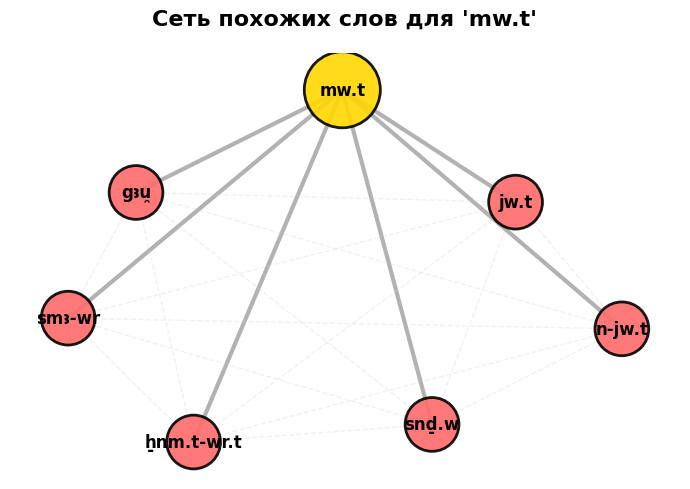

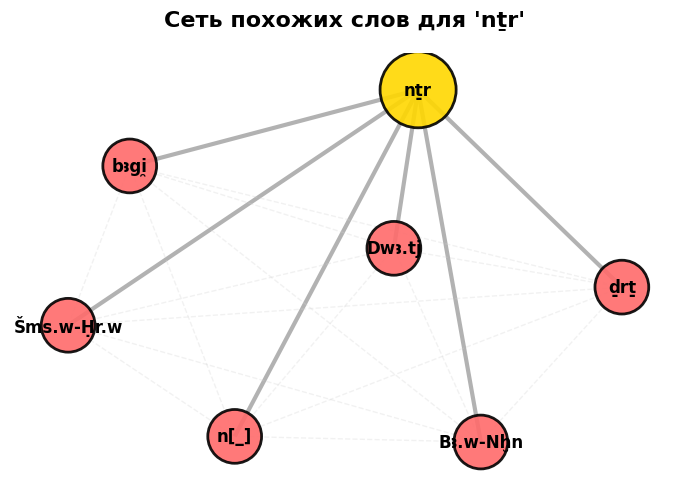

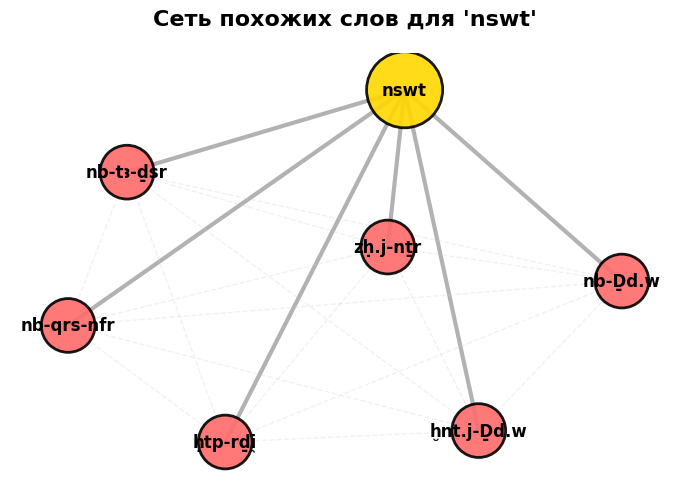

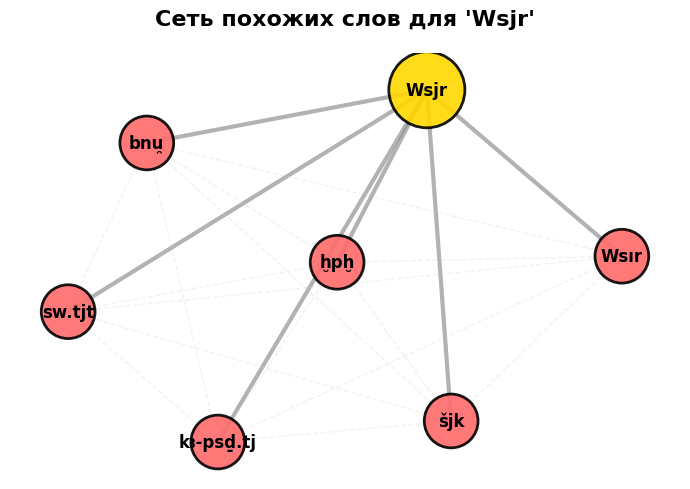

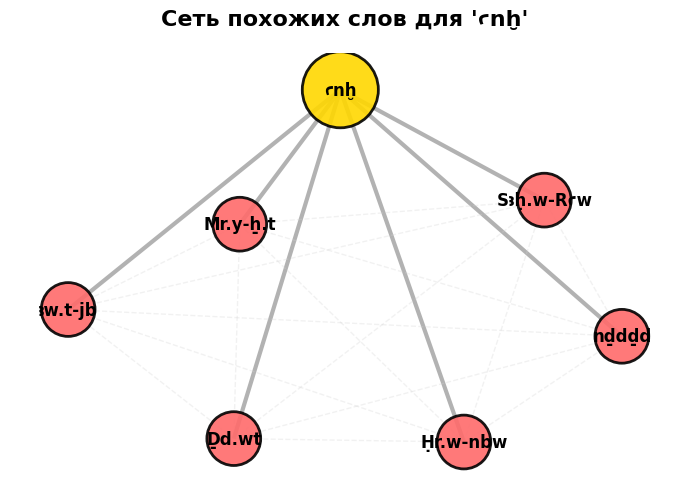

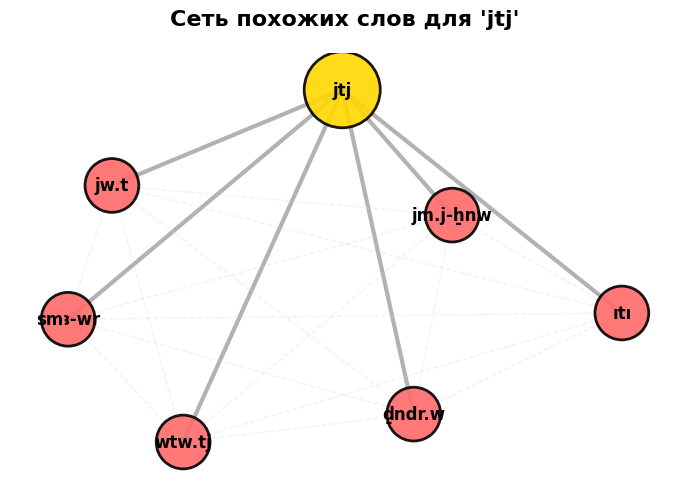

In [ ]:
analyze_egyptian_ego_networks(
    model,
    '/content/drive/MyDrive/Древние языки/ego_networks/'
)